In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import os
os.chdir('./drive/My Drive/TESI/MST3D')

Mounted at /content/drive/


In [2]:
from __future__ import print_function
import os
import sys
import pickle
import time
import numpy as np
import h5py

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import deepst.metrics as metrics
from deepst.datasets import TaxiBJ

In [3]:
import tensorflow as tf
# tf.random.set_seed(2)
# custom layer for branches fusion
class LinearLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(LinearLayer, self).__init__()
    # self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel1 = self.add_weight("kernel1", input_shape[0][1:])
    self.kernel2 = self.add_weight("kernel2", input_shape[1][1:])
    self.kernel3 = self.add_weight("kernel3", input_shape[2][1:])


  def call(self, inputs):
    return (
        tf.math.multiply(inputs[0], self.kernel1)
        + tf.math.multiply(inputs[1], self.kernel2)
        + tf.math.multiply(inputs[2], self.kernel3)
    )

In [14]:
'''
    MST3D
'''

from __future__ import print_function
from keras.layers import (
    Input,
    Conv3D,
    MaxPool3D,
    Dropout,
    Flatten,
    Activation,
    Add,
    Dense,
    Reshape,
    BatchNormalization
)
from keras.models import Model

def mst3d(len_c, len_p, len_t, nb_flow=2, map_height=32, map_width=32, external_dim=8):
    '''
    C - Temporal Closeness
    P - Period
    T - Trend
    external_dim
    '''

    # main input
    main_inputs = []
    outputs = []
    for i, len in enumerate([len_c, len_p, len_t]):
        if len is not None:
            input = Input(shape=(len, map_height, map_width, nb_flow))
            main_inputs.append(input)
            
            # the first convolutional layer has 32 filters and kernel size of (2,3,3)
            # set stride to (2,1,1) to reduce depth
            stride = (1,1,1)
            nb_filters = 32
            conv1 = Conv3D(nb_filters, (2,3,3), padding='same', activation='relu', strides=stride)(input)
            maxPool1 = MaxPool3D((1,2,2))(conv1)
            maxPool1 = BatchNormalization()(maxPool1)
            dropout1 = Dropout(0.25)(maxPool1)
            # print(dropout1.shape[1])

            # the second and third layers have 64 filters. closeness branch has kernel
            # size of (2,3,3). the other branches have kernel size of (1,3,3).
            # Stride is (2,1,1) if previous layer has output depth>2
            nb_filters = 64
            if (i == 0):
              kernel_size = (2,3,3)
            else:
              kernel_size = (1,3,3)
            if (dropout1.shape[1] > 2):
              stride = (1,1,1)
            else:
              stride = (1,1,1)
            
            conv2 = Conv3D(nb_filters, kernel_size, padding='same', activation='relu', strides=stride)(dropout1)
            maxPool2 = MaxPool3D((1,2,2))(conv2)
            maxPool2 = BatchNormalization()(maxPool2)
            dropout2 = Dropout(0.25)(maxPool2)
            # print(dropout2.shape)

            if (dropout2.shape[1] > 2):
              stride = (1,1,1)
            else:
              stride = (1,1,1)

            conv3 = Conv3D(nb_filters, kernel_size, padding='same', activation='relu')(dropout2)
            maxPool3 = MaxPool3D((1,2,2))(conv3)
            maxPool3 = BatchNormalization()(maxPool3)
            dropout3 = Dropout(0.25)(maxPool3)

            outputs.append(dropout3)

    # parameter-matrix-based fusion
    fusion = LinearLayer()(outputs)
    flatten = Flatten()(fusion)

    # fusing with external component
    if external_dim != None and external_dim > 0:
        # external input
        external_input = Input(shape=(external_dim,))
        main_inputs.append(external_input)
        embedding = Dense(10)(external_input)
        embedding = Activation('relu')(embedding)
        h1 = Dense(nb_filters * len_c * map_height/8 * map_width/8)(embedding)
        activation = Activation('relu')(h1)
        main_output = Add()([flatten, activation])

    # reshape and tanh activation
    main_output = Dense(nb_flow * map_height * map_width)(main_output)
    main_output = Reshape((map_height, map_width, nb_flow))(main_output)
    main_output = Activation('tanh')(main_output)

    model = Model(main_inputs, main_output)

    return model



In [5]:
np.random.seed(1337)  # for reproducibility

# parameters
DATAPATH = '../data'
CACHEDATA = True  # cache data or NOT
path_cache = os.path.join(DATAPATH, 'CACHE', 'MST3D')  # cache path
nb_epoch = 100  # number of epoch at training stage
# nb_epoch_cont = 100  # number of epoch at training (cont) stage
batch_size = 64  # batch size
T = 48  # number of time intervals in one day
lr = 0.0002  # learning rate
len_closeness = 4  # length of closeness dependent sequence - should be 6
len_period = 4  # length of peroid dependent sequence
len_trend = 4  # length of trend dependent sequence

nb_flow = 2  # there are two types of flows: inflow and outflow

# divide data into two subsets: Train & Test, of which the test set is the
# last 4 weeks
days_test = 7 * 4
len_test = T * days_test
map_height, map_width = 32, 32  # grid size
path_result = 'RET'
path_model = 'MODEL'
if os.path.isdir(path_result) is False:
    os.mkdir(path_result)
if os.path.isdir(path_model) is False:
    os.mkdir(path_model)
if CACHEDATA and os.path.isdir(path_cache) is False:
    os.mkdir(path_cache)

In [6]:
def build_model(save_model_pic=False):
    model = mst3d(len_closeness, len_period, len_trend, nb_flow, map_height, map_width, external_dim)
    adam = Adam(lr=lr)
    model.compile(loss='mse', optimizer=adam, metrics=[metrics.rmse])
    # model.summary()
    if (save_model_pic):
        from keras.utils.vis_utils import plot_model
        plot_model(model, to_file='TaxiBJ_model.png', show_shapes=True)
    return model

In [7]:
def read_cache(fname):
    mmn = pickle.load(open('preprocessing_taxibj.pkl', 'rb'))

    f = h5py.File(fname, 'r')
    num = int(f['num'].value)
    X_train, Y_train, X_test, Y_test = [], [], [], []
    for i in range(num):
        X_train.append(f['X_train_%i' % i].value)
        X_test.append(f['X_test_%i' % i].value)
    Y_train = f['Y_train'].value
    Y_test = f['Y_test'].value
    external_dim = f['external_dim'].value
    timestamp_train = f['T_train'].value
    timestamp_test = f['T_test'].value
    f.close()

    return X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test

In [8]:
def cache(fname, X_train, Y_train, X_test, Y_test, external_dim, timestamp_train, timestamp_test):
    h5 = h5py.File(fname, 'w')
    h5.create_dataset('num', data=len(X_train))

    for i, data in enumerate(X_train):
        h5.create_dataset('X_train_%i' % i, data=data)
    # for i, data in enumerate(Y_train):
    for i, data in enumerate(X_test):
        h5.create_dataset('X_test_%i' % i, data=data)
    h5.create_dataset('Y_train', data=Y_train)
    h5.create_dataset('Y_test', data=Y_test)
    external_dim = -1 if external_dim is None else int(external_dim)
    h5.create_dataset('external_dim', data=external_dim)
    h5.create_dataset('T_train', data=timestamp_train)
    h5.create_dataset('T_test', data=timestamp_test)
    h5.close()

In [9]:
print("loading data...")
ts = time.time()
fname = os.path.join(path_cache, 'TaxiBJ_C{}_P{}_T{}.h5'.format(
    len_closeness, len_period, len_trend))
if os.path.exists(fname) and CACHEDATA:
    X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = read_cache(
        fname)
    print("load %s successfully" % fname)
else:
    X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = TaxiBJ.load_data(
        T=T, nb_flow=nb_flow, len_closeness=len_closeness, len_period=len_period, len_trend=len_trend, len_test=len_test,
        preprocess_name='preprocessing_taxibj.pkl', meta_data=True, meteorol_data=True, holiday_data=True, datapath=DATAPATH)
    if CACHEDATA:
        cache(fname, X_train, Y_train, X_test, Y_test,
              external_dim, timestamp_train, timestamp_test)

print("\n days (test): ", [v[:8] for v in timestamp_test[0::T]])
print("\nelapsed time (loading data): %.3f seconds\n" % (time.time() - ts))

print('=' * 10)


loading data...
file name:  ../data/TaxiBJ/BJ13_M32x32_T30_InOut.h5


/content/drive/My Drive/TESI/MST3D/deepst/datasets/__init__.py:25: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(fname) as f:
/content/drive/My Drive/TESI/MST3D/deepst/datasets/__init__.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mmax = f['data'].value.max()
/content/drive/My Drive/TESI/MST3D/deepst/datasets/__init__.py:29: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  mmin = f['data'].value.min()
/content/drive/My Drive/TESI/MST3D/deepst/datasets/__init__.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f['data'].value
/content/driv

=====stat=====
data shape: (4888, 2, 32, 32)
# of days: 121, from 2013-07-01 to 2013-10-29
# of timeslots: 5808
# of timeslots (available): 4888
missing ratio of timeslots: 15.8%
max: 1230.000, min: 0.000
=====stat=====
incomplete days:  [b'20130926']


file name:  ../data/TaxiBJ/BJ14_M32x32_T30_InOut.h5
=====stat=====
data shape: (4780, 2, 32, 32)
# of days: 119, from 2014-03-01 to 2014-06-27
# of timeslots: 5712
# of timeslots (available): 4780
missing ratio of timeslots: 16.3%
max: 1292.000, min: 0.000
=====stat=====
incomplete days:  [b'20140304', b'20140313', b'20140323', b'20140326', b'20140401', b'20140402', b'20140409', b'20140410', b'20140412', b'20140422', b'20140501', b'20140526', b'20140618', b'20140627']


file name:  ../data/TaxiBJ/BJ15_M32x32_T30_InOut.h5
=====stat=====
data shape: (5596, 2, 32, 32)
# of days: 122, from 2015-03-01 to 2015-06-30
# of timeslots: 5856
# of timeslots (available): 5596
missing ratio of timeslots: 4.4%
max: 1274.000, min: 0.000
=====stat=====


/content/drive/My Drive/TESI/MST3D/deepst/datasets/TaxiBJ.py:45: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  Timeslot = f['date'].value
/content/drive/My Drive/TESI/MST3D/deepst/datasets/TaxiBJ.py:46: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  WindSpeed = f['WindSpeed'].value
/content/drive/My Drive/TESI/MST3D/deepst/datasets/TaxiBJ.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  Weather = f['Weather'].value
/content/drive/My Drive/TESI/MST3D/deepst/datasets/TaxiBJ.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  Temperature = f['Temperature'].value


shape:  (5856,) (5856, 17) (5856,)
time feature: (5856, 8) holiday feature: (5856, 1) meteorol feature:  (5856, 19) mete feature:  (5856, 28)
XC shape:  (5856, 4, 32, 32, 2) XP shape:  (5856, 4, 32, 32, 2) XT shape:  (5856, 4, 32, 32, 2) Y shape: (5856, 32, 32, 2)
train shape: (4512, 4, 32, 32, 2) (4512, 32, 32, 2) test shape:  (1344, 4, 32, 32, 2) (1344, 32, 32, 2)
(4512, 4, 32, 32, 2)
(4512, 4, 32, 32, 2)
(4512, 4, 32, 32, 2)
(4512, 28)

(1344, 4, 32, 32, 2)
(1344, 4, 32, 32, 2)
(1344, 4, 32, 32, 2)
(1344, 28)


 days (test):  [b'20160222', b'20160223', b'20160225', b'20160303', b'20160306', b'20160307', b'20160308', b'20160309', b'20160310', b'20160313', b'20160314', b'20160315', b'20160316', b'20160317', b'20160320', b'20160321', b'20160322', b'20160328', b'20160329', b'20160331', b'20160401', b'20160402', b'20160403', b'20160404', b'20160405', b'20160407', b'20160408', b'20160409']

elapsed time (loading data): 255.279 seconds



In [10]:
print(len(X_train))
xtrain_np = np.array(X_train[0], dtype=np.float32)
print(xtrain_np.shape)
print(len(Y_train))
ytrain_np = np.array(Y_train, dtype=np.float32)
print(ytrain_np.shape)
print(len(timestamp_train))
print(len(timestamp_test))
print(len(X_test))

4
(4512, 4, 32, 32, 2)
4512
(4512, 32, 32, 2)
4512
1344
4


In [15]:
print("compiling model...")
ts = time.time()
model = build_model(save_model_pic=False)
hyperparams_name = 'TaxiBJ.c{}.p{}.t{}.lr{}'.format(
    len_closeness, len_period, len_trend, lr)
fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

early_stopping = EarlyStopping(monitor='val_rmse', patience=25, mode='min')
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='val_rmse', verbose=0, save_best_only=True, mode='min')

print("\nelapsed time (compiling model): %.3f seconds\n" %
      (time.time() - ts))

print('=' * 10)

compiling model...

elapsed time (compiling model): 0.460 seconds



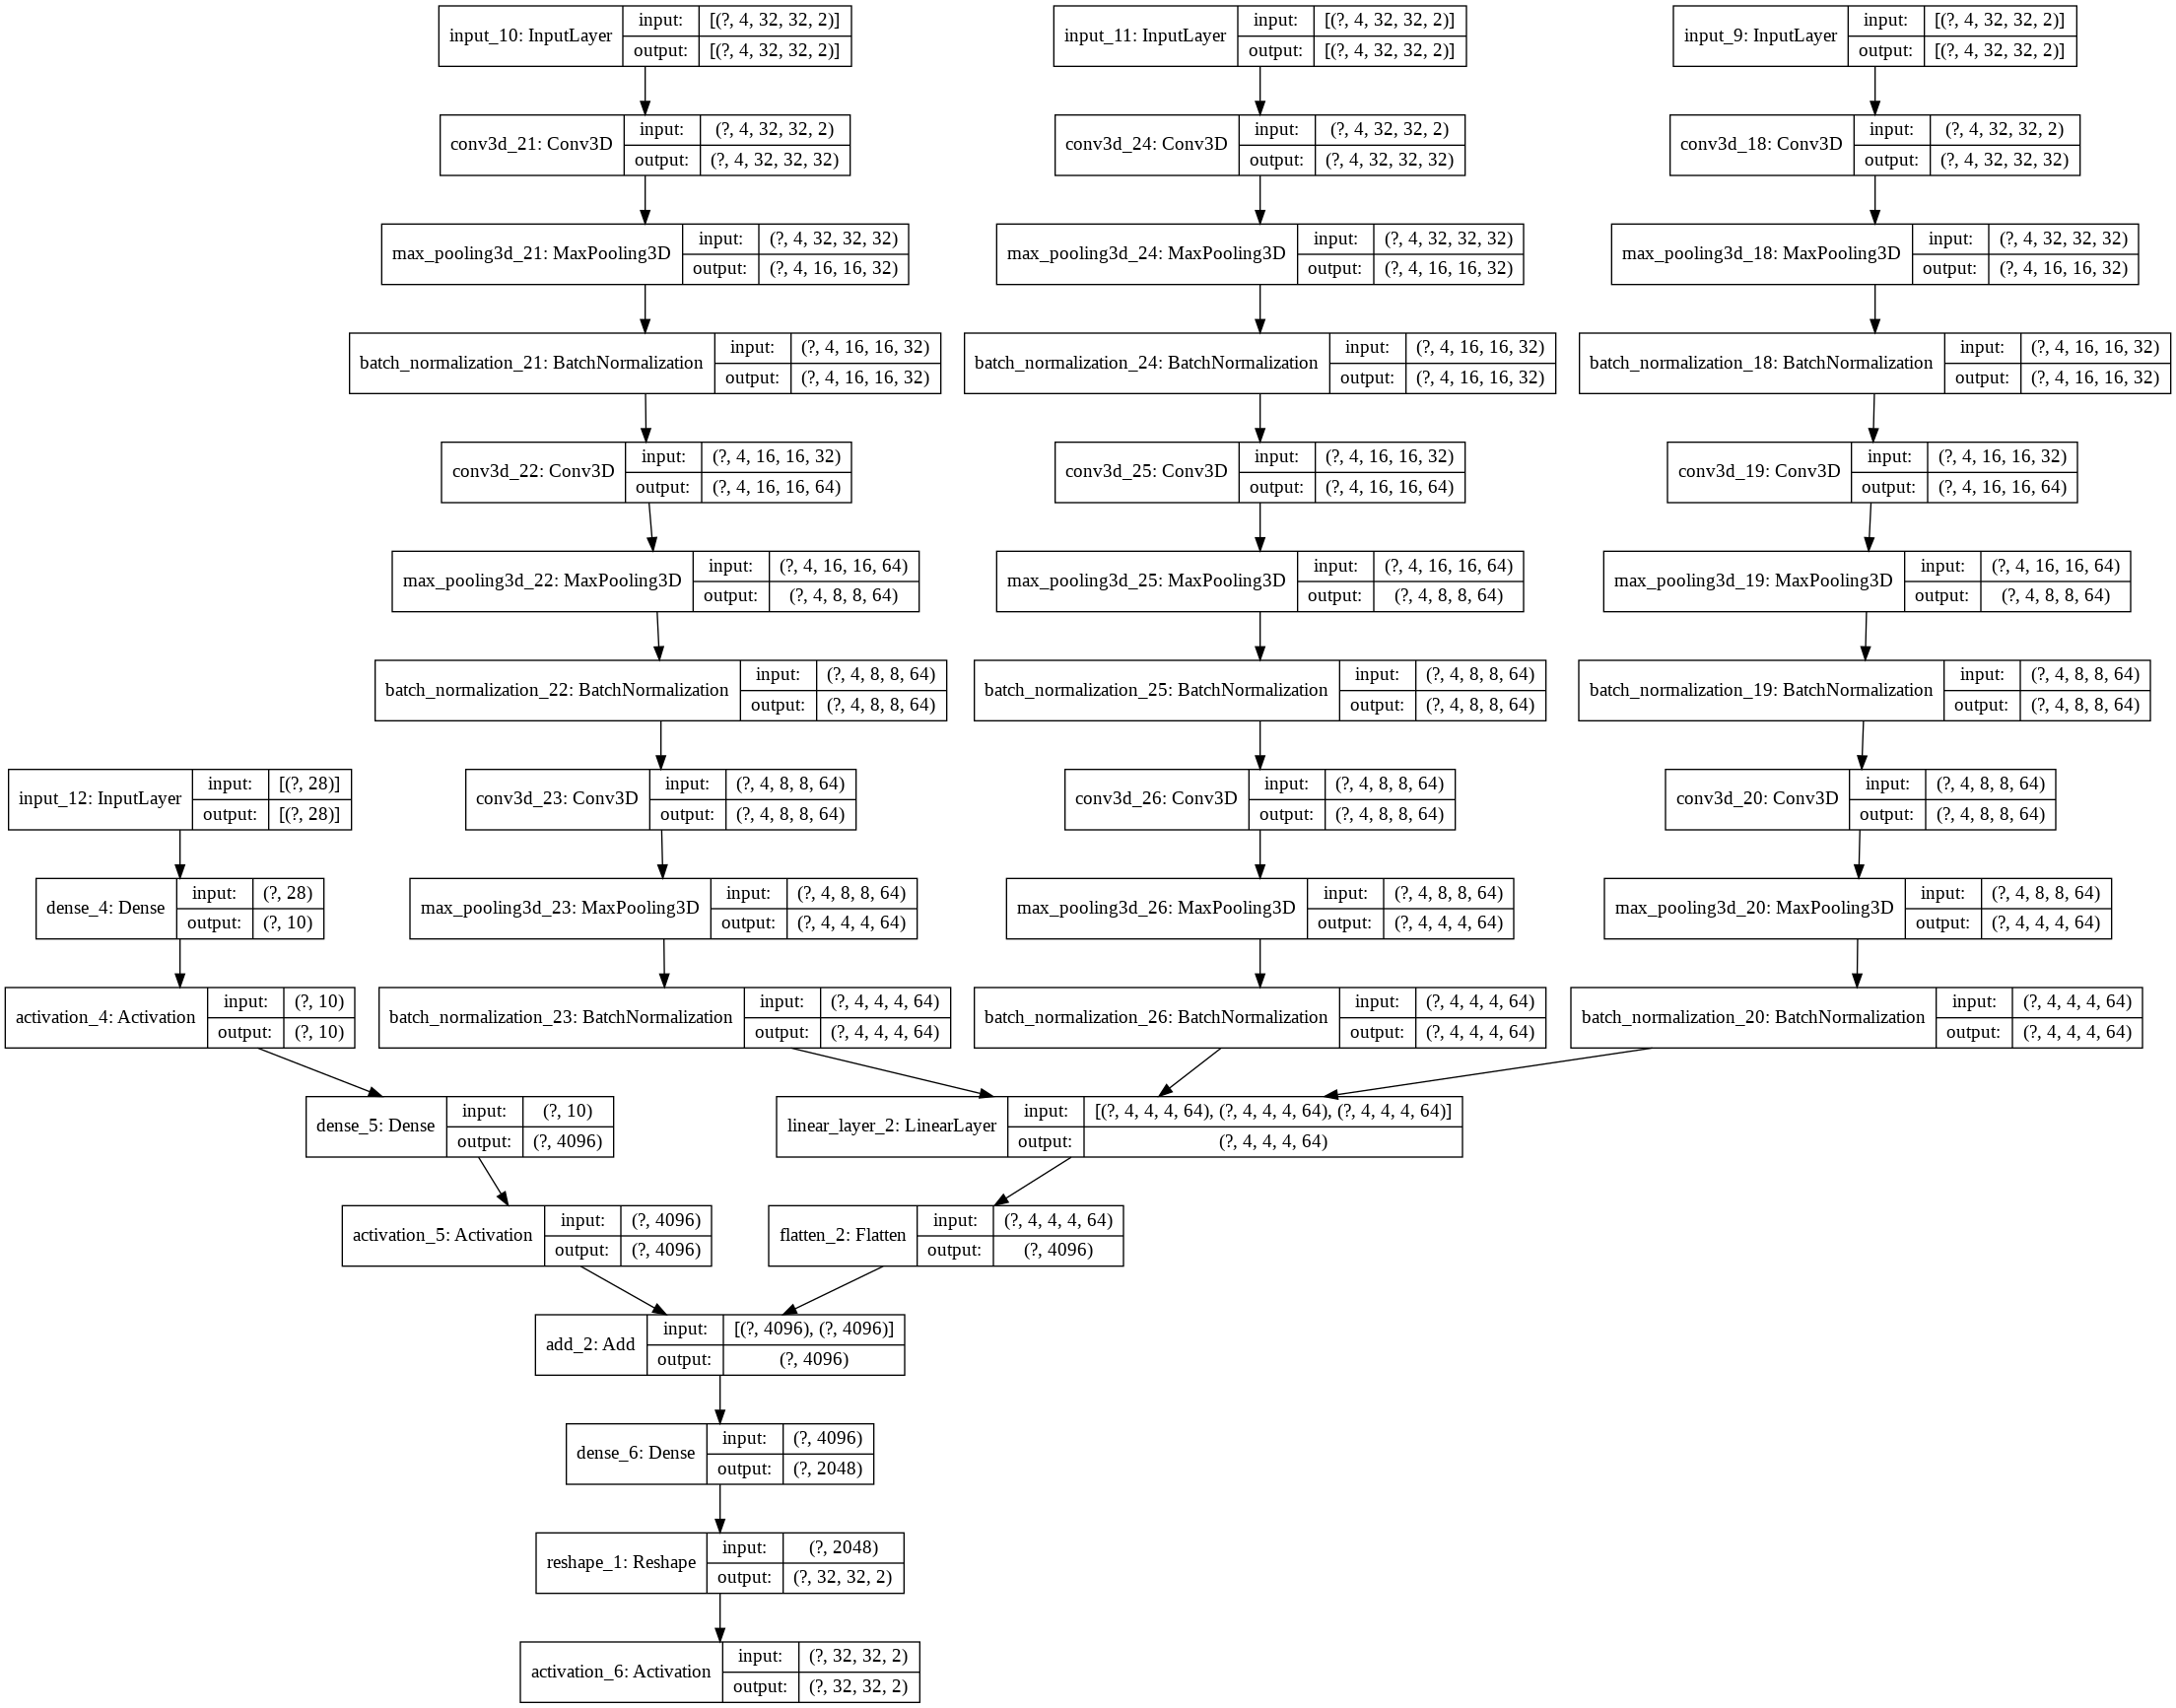

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [22]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 6, 32, 32, 2 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 4, 32, 32, 2 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 4, 32, 32, 2 0                                            
__________________________________________________________________________________________________
conv3d_18 (Conv3D)              (None, 3, 32, 32, 32 1184        input_9[0][0]                    
_______________________________________________________________________________________

In [17]:
print("training model...")
ts = time.time()
history = model.fit(X_train, Y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)
model.save_weights(os.path.join(
    'MODEL', '{}.h5'.format(hyperparams_name)), overwrite=True)
pickle.dump((history.history), open(os.path.join(
    path_result, '{}.history.pkl'.format(hyperparams_name)), 'wb'))
print("\nelapsed time (training): %.3f seconds\n" % (time.time() - ts))


training model...
Epoch 1/100
64/64 [==============================] - 9s 145ms/step - loss: 0.0965 - rmse: 0.2172 - val_loss: 0.4181 - val_rmse: 0.6496
Epoch 2/100
64/64 [==============================] - 9s 133ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.3044 - val_rmse: 0.5542
Epoch 3/100
64/64 [==============================] - 9s 134ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.2057 - val_rmse: 0.4553
Epoch 4/100
64/64 [==============================] - 9s 133ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.1223 - val_rmse: 0.3505
Epoch 5/100
64/64 [==============================] - 9s 133ms/step - loss: 0.0017 - rmse: 0.0416 - val_loss: 0.0669 - val_rmse: 0.2586
Epoch 6/100
64/64 [==============================] - 9s 134ms/step - loss: 0.0016 - rmse: 0.0399 - val_loss: 0.0259 - val_rmse: 0.1600
Epoch 7/100
64/64 [==============================] - 9s 134ms/step - loss: 0.0014 - rmse: 0.0376 - val_loss: 0.0097 - val_rmse: 0.0975
Epoch 8/100
64/64 [==================

In [18]:
print('evaluating using the model that has the best loss on the valid set')

model.load_weights(fname_param)
score = model.evaluate(
    X_test, Y_test, batch_size=Y_test.shape[0], verbose=0)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
        (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2.))

evaluating using the model that has the best loss on the valid set
Test score: 0.000980 rmse (norm): 0.031305 rmse (real): 20.222898


In [6]:
from keras.layers import (Add, Input)
l1 = Input((3,32,32,2))
l2 = Input((1,32,32,2))
l3 = Add()([l1,l2])